### **Tutorial :DLPFC**

This experiment demonstrates the application of SpatialModal, a multi-modal deep learning framework, to the human Dorsolateral Prefrontal Cortex (DLPFC) dataset. The DLPFC dataset is a widely used benchmark in spatial transcriptomics, consisting of 12 tissue slices sequenced using the 10x Visium platform. To illustrate the workflow, we use Slice 151674 as a representative example.

#### **Loading package**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from Spatialmodal.spatialmodal import SpatialModal
from Spatialmodal.reconstruction import RF
from Spatialmodal.data_process import load_ST_file
from Spatialmodal.utils import clustering
import scanpy as sc
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

This step checks for the availability of an NVIDIA GPU (CUDA) to ensure high-performance computation. If a GPU is detected, the program assigns the task to a specific graphics card; otherwise, it falls back to the CPU.

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#### **Loading ST data**

In this step, we load the Spatial Transcriptomics (ST) data for a specific sample. We also import the manually annotated ground truth labels, align them with the existing spatial spots in the AnnData object, and filter out any spots that lack annotation to ensure data quality for subsequent analysis.

In [4]:
sample = '151674'
fold = f"../Data/{sample}"
adata = load_ST_file(fold)
Ann_df = pd.read_csv(fold + f'/{sample}_truth.txt', sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
adata = adata[~pd.isnull(adata.obs['ground_truth'])]
n_clusters = adata.obs['ground_truth'].nunique()

#### **Training the modal**

In this step, we initialize the SpatialModal model by feeding it the preprocessed AnnData object and specifying the computation device. By setting image_use=True, the model integrates morphological information from the tissue images with the transcriptomics data. The train() function executes the optimization process, and the resulting low-dimensional latent representations (embeddings) are stored back into the AnnData object for downstream spatial domain identification.

In [5]:
model = SpatialModal(adata, device=device, epochs=1000, fold=fold, image_use=True, if_img=True)
adata = model.train()

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extracting features: 100%|██████████ [ time left: 00:00 ]
Training SpatialModal: 100%|██████████ [ time left: 00:00 ]


#### **Spatial clustering**

In this final stage, we apply the K-means clustering algorithm to the multi-modal embeddings to partition the spots into discrete spatial domains. To further ensure biological consistency, we apply a spatial refinement step to smooth the cluster assignments. Finally, we evaluate the results using the Adjusted Rand Index (ARI) and visualize the domains alongside the ground truth.

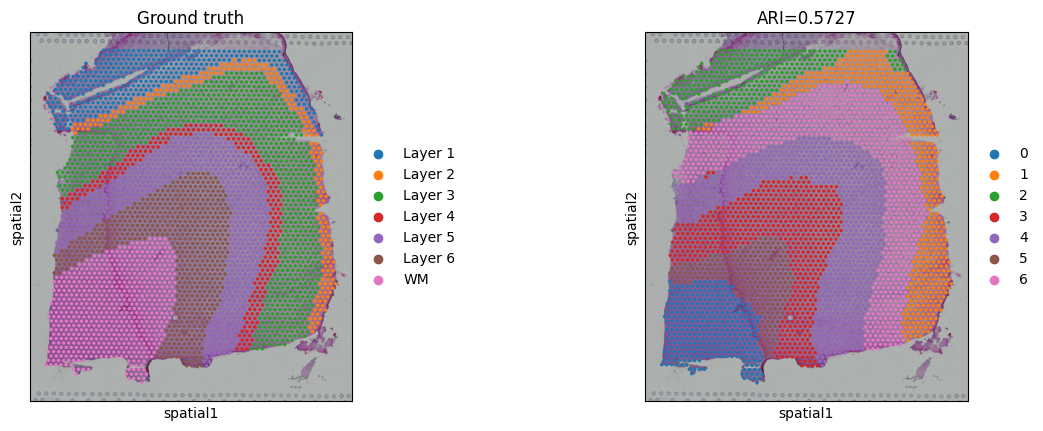

In [ ]:
clustering(adata, n_clusters, radius=50, refinement=True)
ARI = metrics.adjusted_rand_score(adata.obs['ground_truth'], adata.obs['domain'])
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

#### **Gene reconstruction**

In this stage, we utilize the SpatialModal Reconstruction Module (RF) to recover or denoise gene expression by leveraging spatial coordinate information. We first align the spatial coordinates to the model's expected format (coord). The model is then trained for 4000 epochs to learn the mapping between the spatial context and gene expression. The final reconstructed expression matrix, which helps mitigate technical noise and dropouts, is stored in adata.obsm['rec'].

In [7]:
adata.obsm["coord"] = adata.obsm['spatial']
model_rec = RF(adata, epochs=4000, device=device)
adata = model_rec.train('2D')

Epochs:   8%|▊         | 340/4000 [00:02<00:32, 111.17it/s, la:0.0147,rec:0.9444,to:0.0109]

Epochs: 100%|██████████| 4000/4000 [00:36<00:00, 110.56it/s, la:0.0024,rec:0.7191,to:0.0074]


Comparison between original gene expression and the denoised/reconstructed results from the SpatialModal RF module to evaluate performance.

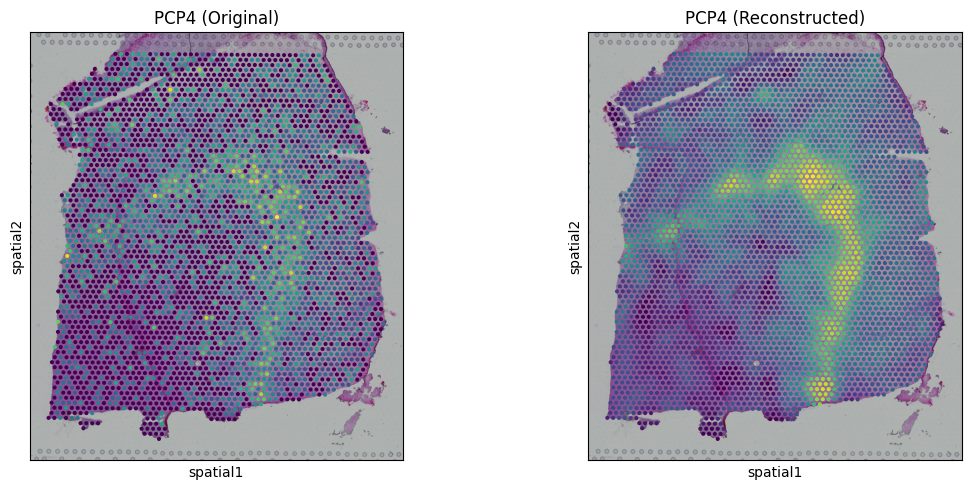

In [ ]:
hvg_names = adata.var_names[adata.var['highly_variable']]

new_adata = sc.AnnData(
    X=adata.obsm['rec'], 
    obs=adata.obs.copy(), 
    var=pd.DataFrame(index=hvg_names)
)
new_adata.uns['spatial'] = {}
new_adata.uns['spatial'][sample] = adata.uns['spatial'][sample]
new_adata.obsm['spatial'] = adata.obsm['spatial']    

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.spatial(adata, 
              color='PCP4', 
              title='PCP4 (Original)',
              gene_symbols='var_names',
              ax=ax[0], 
              show=False)

sc.pl.spatial(new_adata, 
              color='PCP4', 
              title='PCP4 (Reconstructed)', 
              gene_symbols='var_names',
              ax=ax[1], 
              show=False)

plt.tight_layout() # Optimize spacing between plots
plt.show()
